# 🎲 Problem 205 - Dice Game

## Nome: Morsinado de Azevedo Medeiros

Peter has nine four-sided (pyramidal) dice, each with faces numbered 1 to 4.  
Colin has six six-sided (cubic) dice, each with faces numbered 1 to 6.

Peter and Colin roll their dice and compare totals: the highest total wins. The result is a draw if the totals are equal.

What is the probability that Pyramidal Peter beats Cubic Colin? Give your answer rounded to seven decimal places in the form 0.abcdefg.

## 💻 Primeira tentativa (Não deu certo)

A primeira abordagem consistiu na utilização de **simulação de Monte Carlo**.  
O procedimento adotado foi o de gerar um grande número de repetições do lançamento dos dados de cada jogador, registrando a frequência em que a soma de Peter supera a de Colin. A probabilidade é então estimada pela razão entre o número de vitórias de Peter e o total de simulações realizadas.

In [3]:
import random

PETER_DICES = 9
COLIN_DICES = 6

peter_dice_faces = [1,2,3,4]
colin_dice_faces = [1,2,3,4,5,6]

N_TRIALS = 10_000_000

peter_wins = 0

for i in range(N_TRIALS):
    peter_score = sum(random.choices(peter_dice_faces, k=PETER_DICES))
    colin_score = sum(random.choices(colin_dice_faces, k=COLIN_DICES))
    if peter_score > colin_score:
        peter_wins += 1

print(round(peter_wins / N_TRIALS, 7))

0.5731508


## 📉 Limitações da primeira tentativa

Embora tenham sido realizados 10 milhões de lançamentos, o resultado obtido foi aproximadamente 0.5731442, que diverge do valor correto de 0.5731441. A discrepância, embora pequena, é significativa dado o nível de precisão requerido (sete casas decimais). Desse modo, partiu-se para uma abordagem exata.

## 📊 Segunda tentativa (Método exato)

Nesta etapa, optamos por calcular a distribuição exata das somas possíveis, em vez de recorrer à simulação.  
A estratégia consiste em determinar todas as combinações de lançamentos de dados para Peter e Colin e, a partir disso, contar em quantos casos a soma de Peter supera a soma de Colin.

- Para Peter, com 9 dados de 4 faces, o número total de combinações é \(4^9\).  
- Para Colin, com 6 dados de 6 faces, o total é \(6^6\).  
- Todas as combinações possuem a mesma probabilidade de ocorrência.

O passo seguinte é construir, para cada jogador, a **função de massa de probabilidade (PMF)** das somas:  
- Um único dado de \(f\) faces tem distribuição uniforme.  
- A soma de dois dados pode ser obtida por meio da **convolução** das distribuições individuais.  
- Repetindo o processo, obtém-se a distribuição exata da soma de \(n\) dados.  

Assim, aplicamos a convolução 9 vezes para os dados de Peter e 6 vezes para os dados de Colin, obtendo as distribuições necessárias para o cálculo final.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def convolve_uniform(faces, n):
    p = np.ones(faces, dtype=np.int64)
    for _ in range(n - 1):
        p = np.convolve(p, np.ones(faces, dtype=np.int64))
    return p

# Contagens de cada soma (índices 0.. correspondem a somas mínimas)
p_pmf = convolve_uniform(4, 9)   # somas de 9 a 36
c_pmf = convolve_uniform(6, 6)   # somas de 6 a 36

### ⚖️ Distribuições de Peter (9×d4) e Colin (6×d6)

Uma vez construída a função de massa de probabilidade (PMF) para cada jogador, podemos visualizar as distribuições das somas possíveis.

- Para **Peter**, a soma varia entre 9 e 36, resultante do lançamento de 9 dados de 4 faces.  
- Para **Colin**, a soma varia entre 6 e 36, resultante do lançamento de 6 dados de 6 faces.  

Cada ponto da curva corresponde à probabilidade de ocorrência de uma soma específica.  
O formato das distribuições é semelhante a uma curva em “sino discreta”, pois a combinação de múltiplos dados tende a concentrar valores em torno da média.  

Vale observar que:  
- A média esperada para Peter é $(9 \times 2.5 = 22.5)$.  
- A média esperada para Colin é $(6 \times 3.5 = 21.0)$.  

O gráfico a seguir ilustra essas distribuições lado a lado, permitindo comparar diretamente a chance de cada soma. Essa comparação é essencial, pois o próximo passo consiste em utilizar essas distribuições para calcular a probabilidade de Peter obter um valor maior do que Colin.

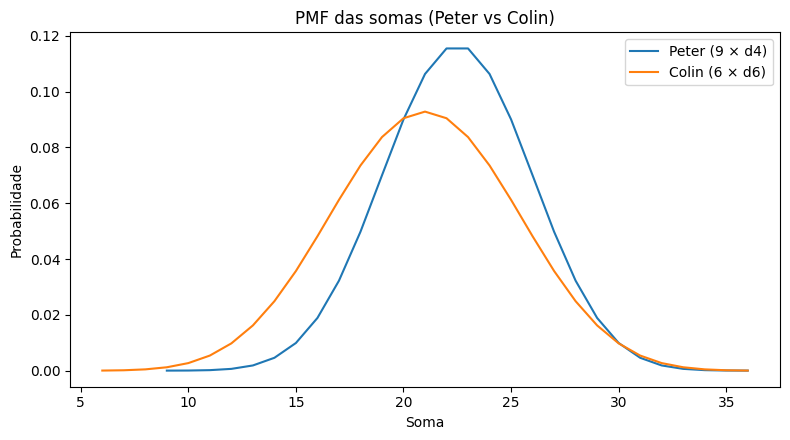

In [6]:
peter_pmf_counts = convolve_uniform(4, 9)   # [9..36]
colin_pmf_counts = convolve_uniform(6, 6)    # [6..36]

peter_total_outcomes = 4**9
colin_total_outcomes = 6**6

peter_pmf = peter_pmf_counts / peter_total_outcomes
colin_pmf = colin_pmf_counts / colin_total_outcomes

x_p = np.arange(9, 9 + len(peter_pmf))
x_c = np.arange(6, 6 + len(colin_pmf))

plt.figure(figsize=(8,4.5))
plt.plot(x_p, peter_pmf, label="Peter (9 × d4)")
plt.plot(x_c, colin_pmf, label="Colin (6 × d6)")
plt.title("PMF das somas (Peter vs Colin)")
plt.xlabel("Soma")
plt.ylabel("Probabilidade")
plt.legend()
plt.tight_layout()
plt.show()

## 📈 CDF de Colin (≤)

Para avançar no cálculo da probabilidade de vitória de Peter, precisamos determinar, para cada soma possível `s_p` de Peter, a probabilidade de que Colin obtenha uma soma menor que `s_p`.  

Essa informação é obtida a partir da **função de distribuição acumulada (CDF)** de Colin.  
A CDF em um ponto \(k\) é definida como:

$[
F_C(k) = P(C \leq k)
]$

Assim, a probabilidade que nos interessa é:

$[
P(C < s_p) = F_C(s_p - 1).
]$

Construindo a CDF de Colin a partir de sua PMF, obtemos a curva acumulada apresentada abaixo.  
Ela indica, para cada valor possível da soma de Colin, a probabilidade de obter um resultado menor ou igual a esse valor.  
Esse recurso será fundamental no próximo passo, quando combinaremos as distribuições para calcular \(P(Peter > Colin)\).

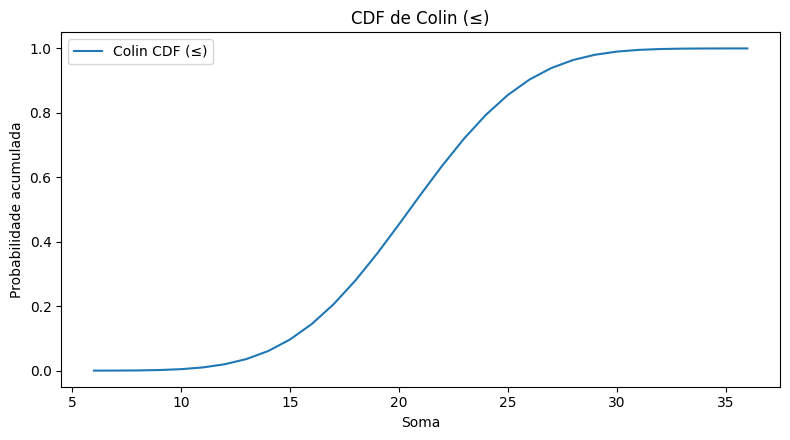

In [7]:
colin_cdf = np.cumsum(colin_pmf)
plt.figure(figsize=(8,4.5))
plt.plot(np.arange(6, 6 + len(colin_cdf)), colin_cdf, label="Colin CDF (≤)")
plt.title("CDF de Colin (≤)")
plt.xlabel("Soma")
plt.ylabel("Probabilidade acumulada")
plt.legend()
plt.tight_layout()
plt.show()

## ✅ Probabilidade final

Com as distribuições já obtidas, podemos calcular diretamente a probabilidade de vitória de Peter.  
A lógica é a seguinte:

1. Para cada soma possível $( s_p )$ de Peter:  
   - Calculamos $( P(Peter = s_p) )$, a probabilidade de Peter obter exatamente aquela soma.  
   - Consultamos $( P(Colin < s_p) )$, já disponível pela CDF de Colin.  

2. Multiplicamos esses valores, obtendo a probabilidade conjunta de Peter ter a soma $( s_p )$ e, simultaneamente, Colin ter uma soma menor.  

3. Somamos esses produtos para todas as somas possíveis de Peter:

$$[
P(Peter > Colin) = \sum_{s_p} P(Peter = s_p) \cdot P(Colin < s_p).
]$$

O resultado desse procedimento é a probabilidade exata de que a soma de Peter seja maior do que a de Colin.  
O valor obtido é aproximadamente **0.5731441**, arredondado a sete casas decimais, atendendo ao enunciado do problema.

In [8]:
wins = 0
min_peter = 9
min_colin = 6
colin_cdf_counts = np.cumsum(colin_pmf_counts)

for i, cnt_p in enumerate(peter_pmf_counts):
    s = min_peter + i
    j = s - 1 - min_colin
    if j >= 0:
        wins += cnt_p * colin_cdf_counts[min(j, len(colin_cdf_counts)-1)]

prob = wins / ( (4**9) * (6**6) )
print(f"P(Peter > Colin) = {prob:.10f}")
print(f"Arredondado a 7 casas: {prob:.7f}")

P(Peter > Colin) = 0.5731440768
Arredondado a 7 casas: 0.5731441


![Alt text](./figures/project_euler_205_answered.png "Project Euler 205 Answered")